In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.examples.two_moons import TwoMoons

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
two_moons = TwoMoons()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = two_moons.prepare_data(100000)
observed_data = two_moons.observed_data()
two_moons.check_normalizer()

Training Theta Shape: torch.Size([100000, 2])
Training Data Shape: torch.Size([100000, 2])
Validation Theta Shape: torch.Size([10000, 2])
Validation Data Shape: torch.Size([10000, 2])
Normalization and denormalization process is consistent for both parameters and observed data.


In [5]:
two_moons.get_info()

theta_normalizer uses device: cpu
data_normalizer uses device: cpu


In [6]:
train_theta_norm.shape , train_data_norm.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

# Initialise the Model

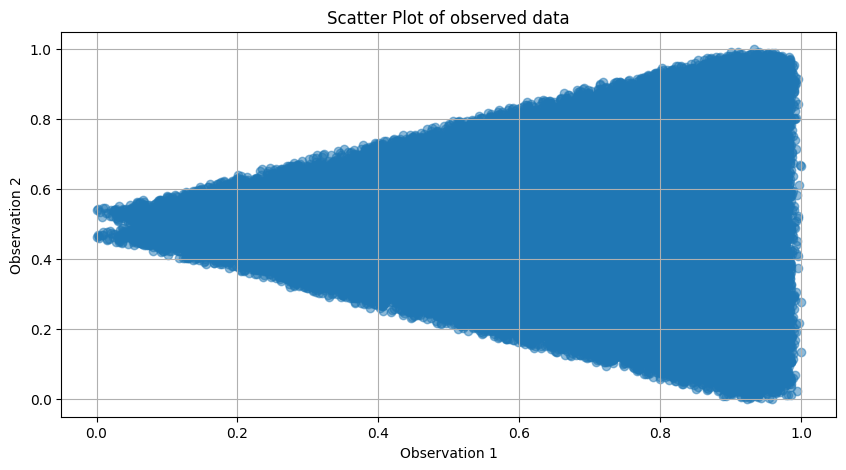

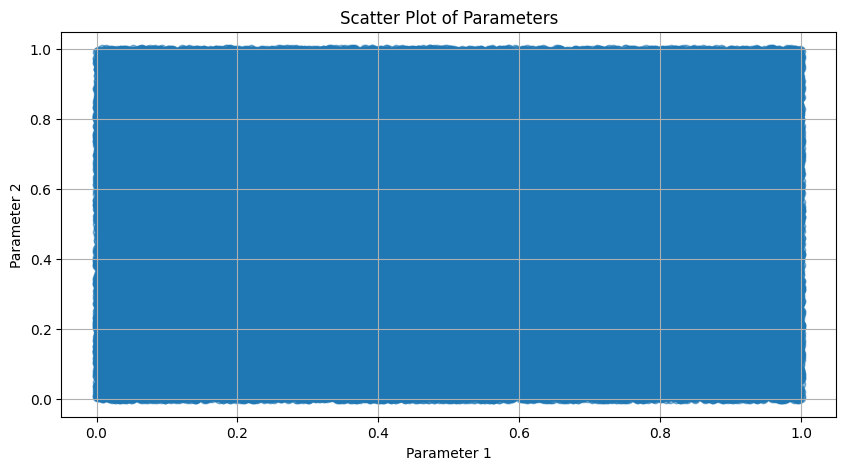

In [7]:
two_moons.plot_observation(train_data_norm)
two_moons.plot_prior(train_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 2
latent_dim = 10
conditional_dim = 2
encoder_hidden_dims = [128]
decoder_hidden_dims = [1024,1024]
activation_fn = nn.LeakyReLU(0.1)

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn,
                w_recon=1.0, 
                w_misfit=1.0)


optimizer = optim.AdamW(network.parameters(), lr=1e-4)


train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=4024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=4024, shuffle=False)


print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
    )
    (fc_mean): Linear(in_features=128, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=12, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): LeakyReLU(negative_slope=0.1)
    )
    (final_layer): Linear(in_features=1024, out_features=2, bias=True)
  )
)


In [9]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=100,
                    num_cycles = 4,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= two_moons.simulator,
                    patience=100)

Using CPU for training.
Epoch 1/100: Beta: 0.0, total_loss: 0.4113, recon_loss: 0.2534, misfit_loss: 0.1579, kl_div: 0.0000
Epoch 1/100 Validation: total_loss: 0.2669, recon_loss: 0.1886, misfit_loss: 0.0782, kl_div: 0.0000

Epoch 1: Validation loss improved to 0.0000
Epoch 2/100: Beta: 0.1, total_loss: 0.2547, recon_loss: 0.1437, misfit_loss: 0.0788, kl_div: 0.0321
Epoch 2/100 Validation: total_loss: 0.2117, recon_loss: 0.1299, misfit_loss: 0.0548, kl_div: 0.0270

Epoch 2: Validation loss improved to 0.0000
Epoch 3/100: Beta: 0.2, total_loss: 0.2105, recon_loss: 0.1223, misfit_loss: 0.0449, kl_div: 0.0432
Epoch 3/100 Validation: total_loss: 0.1806, recon_loss: 0.1146, misfit_loss: 0.0342, kl_div: 0.0318

Epoch 3: Validation loss improved to 0.0000
Epoch 4/100: Beta: 0.2, total_loss: 0.1813, recon_loss: 0.1162, misfit_loss: 0.0297, kl_div: 0.0353
Epoch 4/100 Validation: total_loss: 0.1624, recon_loss: 0.1137, misfit_loss: 0.0250, kl_div: 0.0237

Epoch 4: Validation loss improved to 0.0

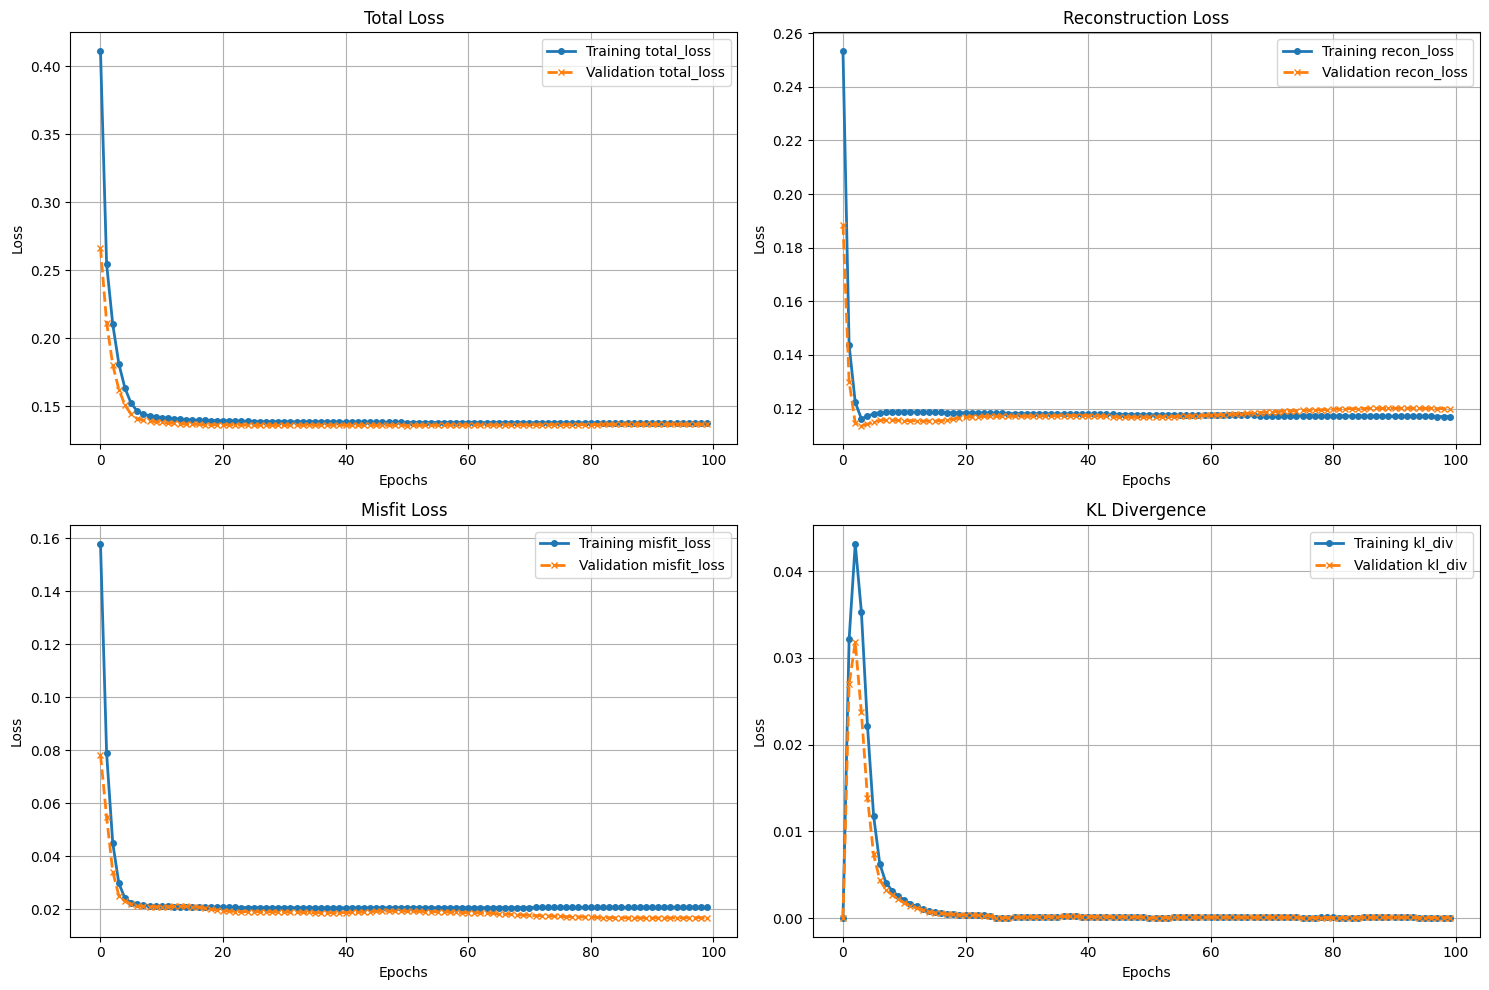

In [10]:
network.plot_loss()

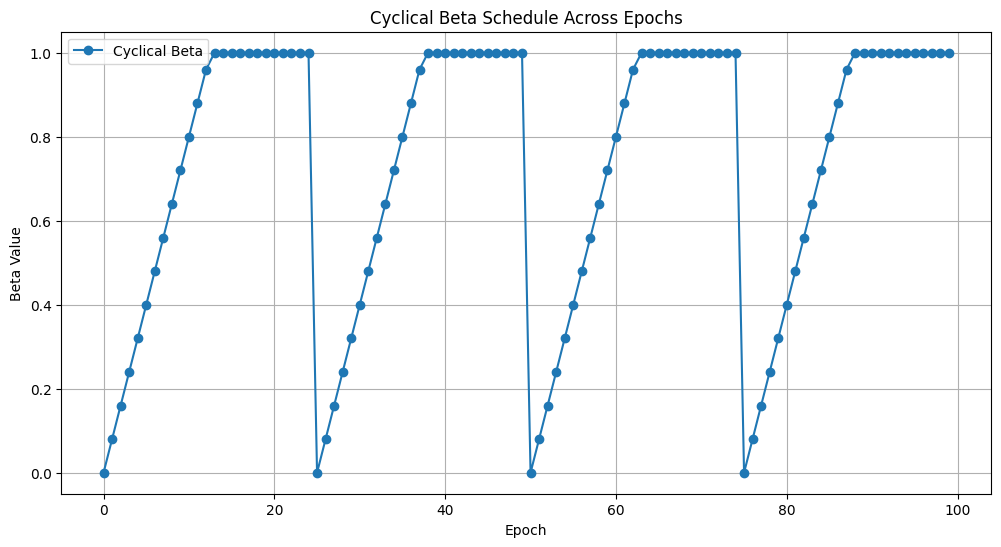

In [11]:
network.plot_beta()

# Inference

In [18]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


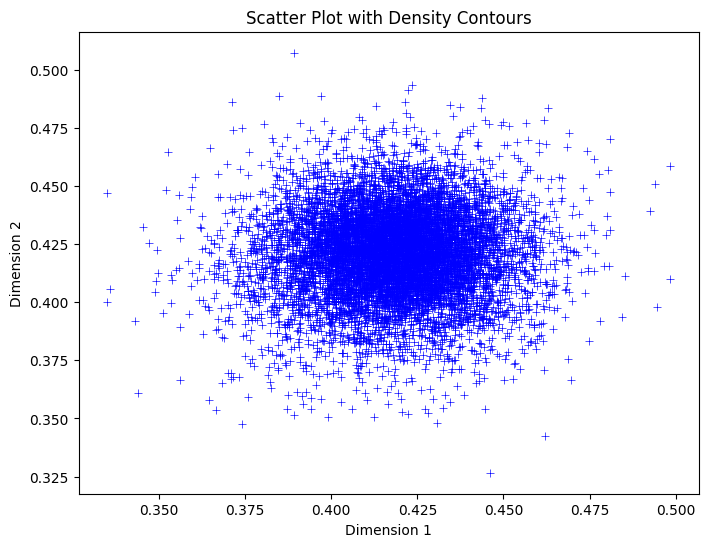

In [19]:
two_moons.plot_posterior(post)

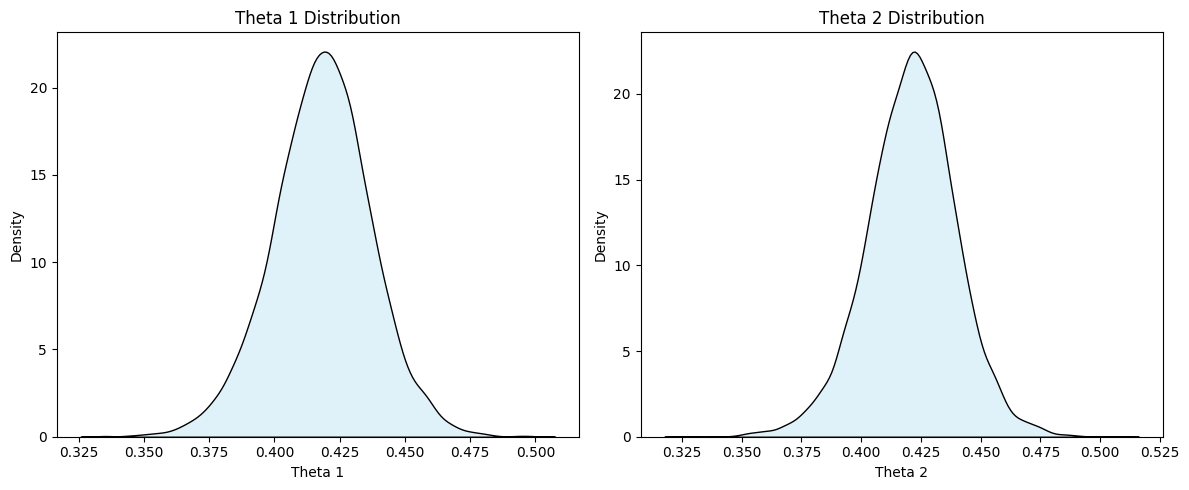

In [20]:
two_moons.posterior_hist(post, kde = True)
post = theta_normalizer.inverse_transform(post)

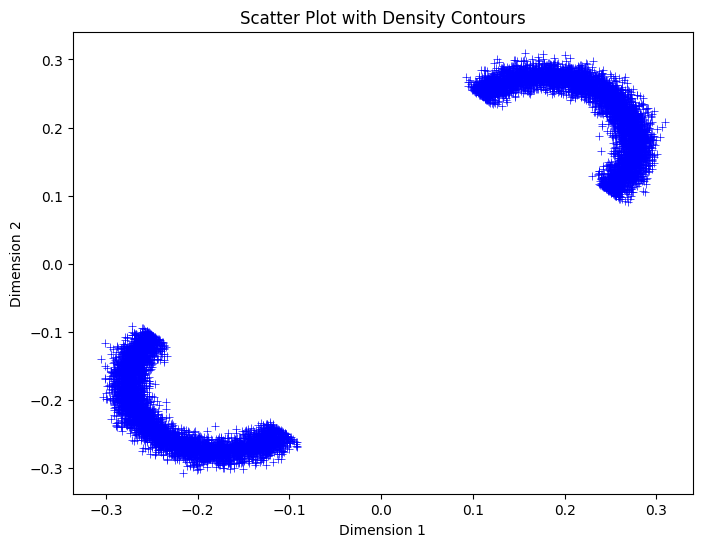

In [15]:
two_moons.analytic_posterior()

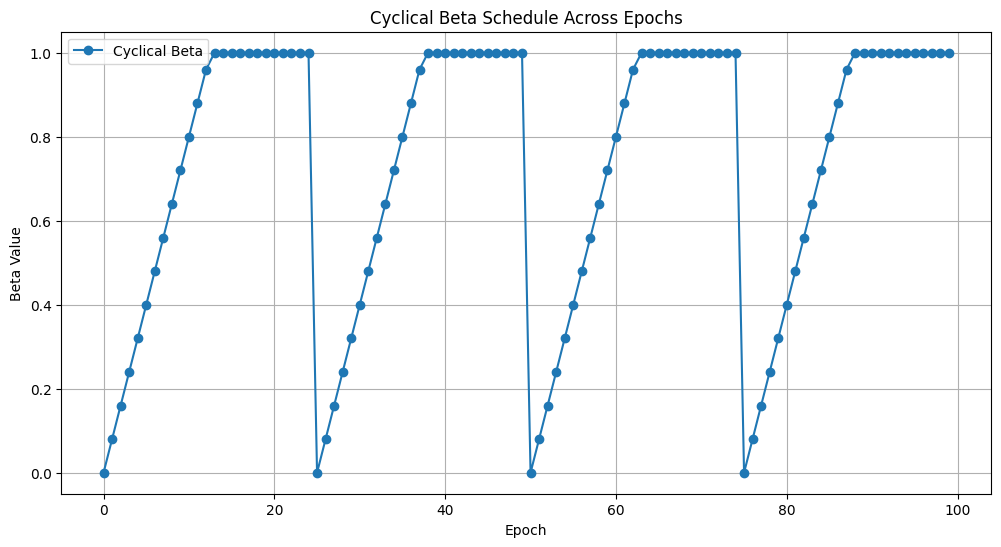

In [16]:
import matplotlib.pyplot as plt
def calculate_beta(epoch, total_epochs, n_cycle, ratio=0.5, start=0, stop=1):
    """
    Calculate the cyclical beta value for KL divergence regularization based on the current epoch.
    
    Parameters:
    epoch (int): Current training epoch.
    total_epochs (int): Total number of epochs for training.
    n_cycle (int): Number of cycles over total epochs.
    ratio (float): Portion of the cycle for beta to increase.
    start (float): Starting value of beta.
    stop (float): Stopping value of beta.

    Returns:
    float: Calculated beta value.
    """
    # Calculate the period of each cycle and the step for linear increase
    period = total_epochs / n_cycle
    step = (stop - start) / (period * ratio)
    
    # Determine the current cycle
    cycle = int(epoch // period)
    cycle_epoch = epoch % period

    # Increase beta linearly for a portion of the cycle, then hold
    if cycle_epoch < (period * ratio):
        beta = start + cycle_epoch * step
    else:
        beta = stop

    return beta

# Parameters for the test
total_epochs = 100  # Total number of epochs for the test
n_cycle = 4        # Number of cycles
ratio = 0.5        # Portion of the cycle to increase beta

# Generate beta values for each epoch
beta_values = [calculate_beta(epoch, total_epochs, n_cycle, ratio) for epoch in range(total_epochs)]

# Plotting the beta values
plt.figure(figsize=(12, 6))
plt.plot(beta_values, label='Cyclical Beta', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Beta Value')
plt.title('Cyclical Beta Schedule Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
beta

NameError: name 'beta' is not defined